In [88]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
from random import randint
from copy import deepcopy
import pickle as pkl
import argparse

from torch import nn
from models import AutoEncoder, AutoEncoderSimple
from skimage.transform import rescale

sys.path.append('../../src')
sys.path.append('../../src/vae')
sys.path.append('../../src/vae/models')
sys.path.append('../../src/dsets/cosmology')
from dset import get_dataloader
from model import init_specific_model
from losses import get_loss_f, _reconstruction_loss
from training import Trainer
from viz import viz_im_r, cshow
from sim_cosmology import p

sys.path.append('../../lib/trim')
# trim modules
from trim import DecoderEncoder

# ICA
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## VAE on cosmology data

In [81]:
# create dir
out_dir = opj(p.out_dir, p.dirname)
os.makedirs(out_dir, exist_ok=True)  

# seed
random.seed(p.seed)
np.random.seed(p.seed)
torch.manual_seed(p.seed)

# get dataloaders
train_loader = get_dataloader(p.data_path, 
                              batch_size=p.train_batch_size)
im = iter(train_loader).next()[0].to(device)

# data matrix
X = train_loader.dataset.imgs.reshape(-1, 64*64)

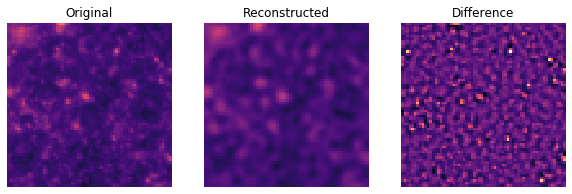

reconstruction error: 71.14058323005654


In [82]:
# transformer = FastICA(n_components=500, max_iter=50000, random_state=0)
# S_ = transformer.fit_transform(X)
# A_ = transformer.mixing_
# # SAVE
# pkl.dump({'S': S_, 'A': A_}, open('results/ICA_n_components=500.pkl', 'wb'))

# # reconstruction
# recon = np.dot(S_, A_.T) - transformer.mean_
# viz_im_r(X[0].reshape((64,64)), recon[0].reshape((64,64)))
# print('reconstruction error:', np.linalg.norm(X - recon))

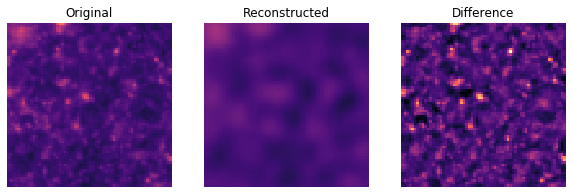

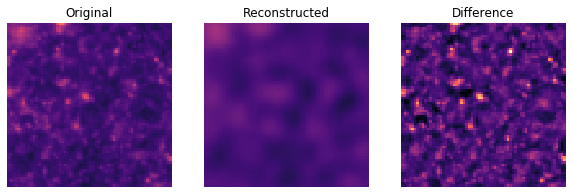

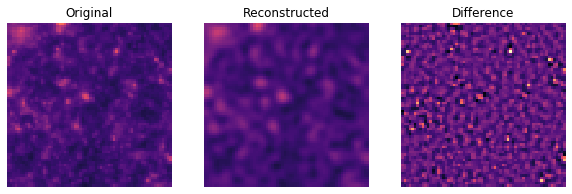

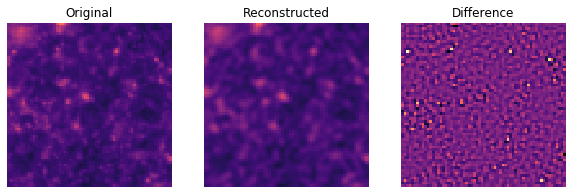

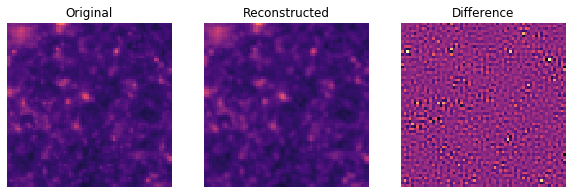

In [84]:
results = []
for n_comp in [50, 100, 500, 1000, 2000]:
    dic = pkl.load(open('results/ICA_n_components={}.pkl'.format(n_comp), 'rb'))
    S = dic['S']
    A = dic['A']
    recon = np.dot(S, A.T)
    viz_im_r(X[0].reshape((64,64)), recon[0].reshape((64,64)))

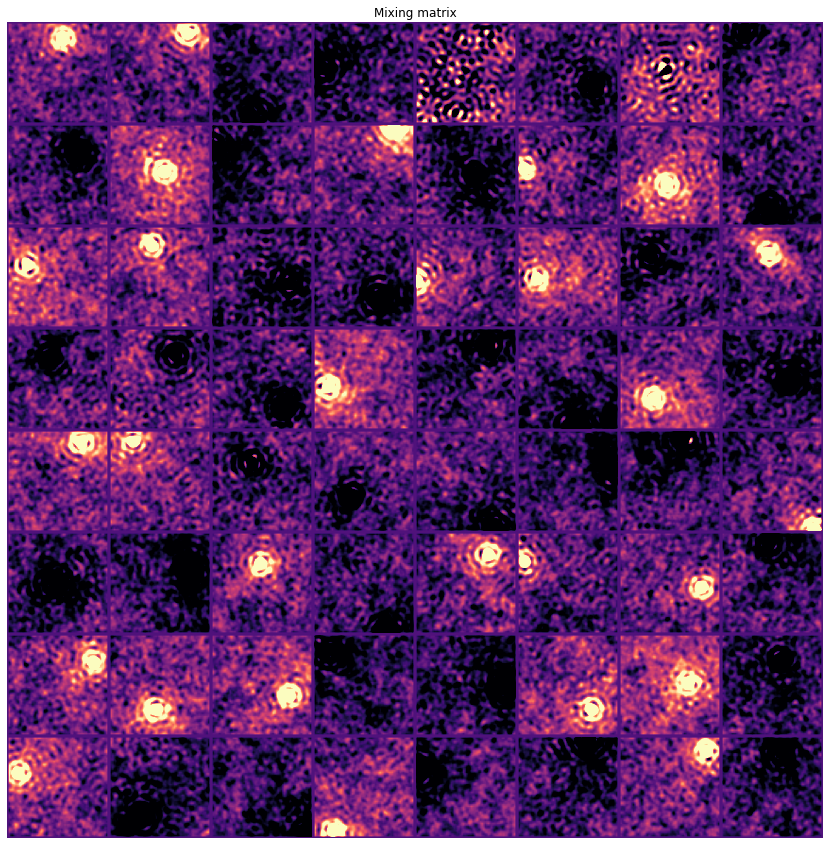

In [99]:
dic = pkl.load(open('results/ICA_n_components={}.pkl'.format(500), 'rb'))
S = dic['S']
A = dic['A']

plt.figure(figsize=(15,15))
p = 64 + 2
n_row = 8
n_col = 8
mosaic = np.zeros((p*n_row,p*n_col))
indx = 0
normalize = False
for i in range(n_row):
    for j in range(n_col):
        im = A[:,indx].reshape((64,64))
        if normalize:
            im = (im-np.min(im))
            im = im/np.max(im)
        mosaic[i*p:(i+1)*p,j*p:(j+1)*p] = np.pad(im,(1,1),mode='constant')
        indx += 1
plt.title("Mixing matrix")
plt.imshow(rescale(mosaic,4,mode='constant'), cmap='magma', vmax=0.15, vmin=-0.05)
plt.axis('off')    
plt.show() 